# FD2Dpy

This notebook implements forward and adjoint simulations of the 2-D scalar wave equation

\begin{equation}
\frac{1}{c^2(\mathbf{x})} \frac{\partial^2}{\partial t^2} u(\mathbf{x},t) - \Delta u(\mathbf{x},t) = f(\mathbf{x},t)\,,
\end{equation}

using a second-order, staggered-grid finite-difference method.

# 0. Python packages and input files
We start with the input of some Python packages and a few lines of code to make nicer figures. Also, we read all the necessary input files.

In [1]:
import filters as filters
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

plt.rcParams["font.family"] = "Times"
plt.rcParams.update({'font.size': 50})
plt.rcParams['xtick.major.pad']='12'
plt.rcParams['ytick.major.pad']='12'

In [2]:
# Load channel locations.
channels_x=np.load('./IO/channels_x.npy')
channels_y=np.load('./IO/channels_y.npy')

# Load time axis.
t_data=np.load('./IO/time.npy')

# Read f-k-filtered reverse data.
data=np.load('./IO/cct_reverse_cropped.npy')

# 1. Input parameters

## 1.1. Spatial and temporal discretisation

The numerical method that we use to solve the above wave equation rests on a finite-difference discretisation in space and time. Hence, in addition to the size of the domain, we need to define the number of spatial grid points in $x$- and $y$-direction, as well as the time increment and the total number of time steps.

In [3]:
# Dimensions of the domain [m].
Lx=250.0
Ly=250.0
# Number of grid points in x- and y-directions.
nx=501
ny=501
# Time increment [s].
dt=0.0003
# Number of time steps.
nt=int(t_data[-1]/dt)

In [4]:
# Make coordinate lines.
x=np.linspace(0.0,Lx,nx)
y=np.linspace(0.0,Ly,ny)
# Matrix version for plotting
xx,yy=np.meshgrid(x,y)
xx=xx.transpose()
yy=yy.transpose()

## 1.2. Velocity distribution

The propagation of the wave is largely controlled by the properties of the medium, that is, the distribution of the wave speed $c$ in space. This distribution can be defined below.

In [49]:
# Define velocity distribution.
c=590.0*np.ones([nx,ny])

# Plot velocity distribution.
if False:
    plt.subplots(1, figsize=(15,15))
    plt.pcolor(xx,yy,c,cmap='Greys')
    plt.xlabel('x [m]',labelpad=15)
    plt.ylabel('y [m]',labelpad=15)
    plt.title('velocity distribution [m/s]',pad=20)
    plt.grid()
    plt.tight_layout()
    plt.show()

## 1.3. Frequency content

With a finite number of grid points, we cannot accurately simulate the propagation of waves with arbitrary frequency. Very low frequencies cannot be simulated because they may correspond to wavelengths that are larger than the computational domain. The same is true for very high frequencies because they correspond to wavelengths that may be too short for being represented accurately on a grid with rather coarse spacing. Hence, we need to ensure that the source of the wavefield only acts within a certain frequency band for which we expect reasonably accurate solutions. This frequency band is defined below.

In [51]:
# Lower cutoff frequency [Hz]
cutoff_low=15.0
# Upper cutoff frequency [Hz]
cutoff_high=30.0

## 1.4. Source and receiver locations

Below we define the location of the source and the locations of the receivers.

In [52]:
# x- and y-coordinates of the source [m].
x_src=channels_x[0]
y_src=channels_y[0]

# x- and y-coordinates of the receiver locations [m].
x_rec=channels_x
y_rec=channels_y

## 1.5. Adjoint parameters

For the computation of sensitivity kernels, the forward wavefield needs to be stored. To avoid excessive storage requirements, we only store the wavefield at a smaller (coarser) number of time steps.

In [53]:
# Store forward wavefield every nt_store time steps only to save storage space.
nt_store=5
# Time steps where forward field is stored for adjoint runs.
i_store=np.arange(0,nt,nt_store,dtype='int')

# 2. Initialisation

Prior to the actual numerical solution of the wave equation, we perform a few initialisation steps.

## 2.1. Grid spacing and stability

In order to have an a priori estimate of solution quality and stability, we compute some easy diagnostics.

In [54]:
# Compute grid spacing.

dx=Lx/float(nx-1)
dy=Ly/float(ny-1)

print('grid spacing in x-direction: %g m' % dx)
print('grid spacing in y-direction: %g m' % dy)

# Compute stability criterion.

dt_max=0.5*np.minimum(dx,dy)/np.amax(c)
print('maximum allowable time step to ensure stability: %g s' % dt_max)
print('current time step: %g s' % dt)

# Grid points per minimum wavelength.
lambda_min=np.min(c)/cutoff_high
print('minimum wavelength: %g m' % lambda_min)
print('grid points per minimum wavelength: %g (recommended at least 20)' % (lambda_min/np.max([dx,dy])))

grid spacing in x-direction: 0.5 m
grid spacing in y-direction: 0.5 m
maximum allowable time step to ensure stability: 0.000423729 s
current time step: 0.0003 s
minimum wavelength: 19.6667 m
grid points per minimum wavelength: 39.3333 (recommended at least 20)


## 2.2. Source-time function

The source time function is the time evolution of the source $f$. It is controlled by the frequency band that we defined above.

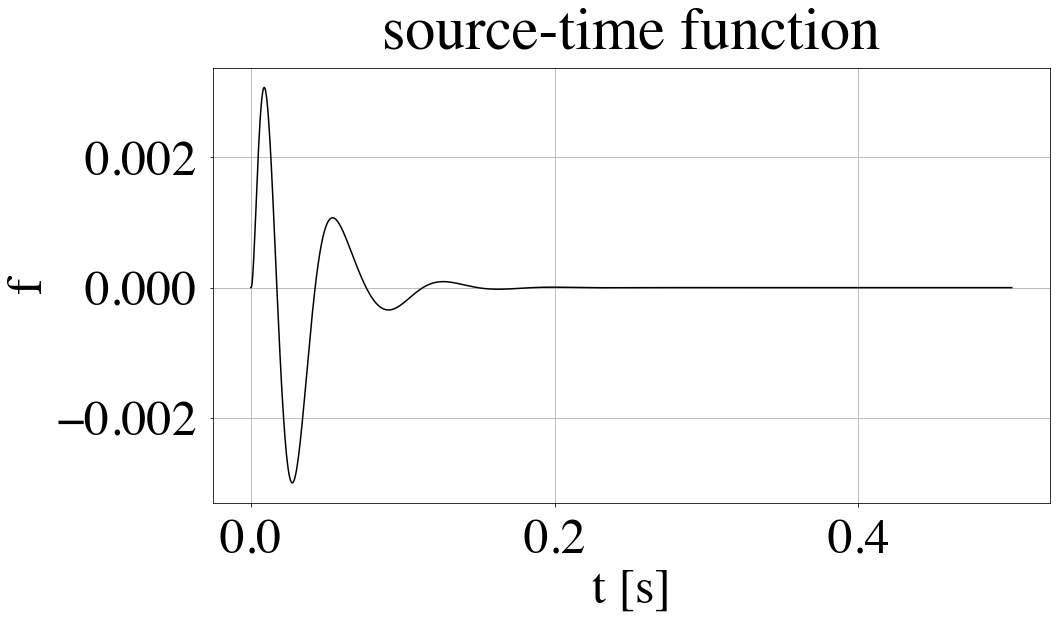

In [55]:
# Make source-time function.
t=np.arange(0.0,float(nt)*dt,dt)
f=np.zeros(len(t))
f[0]=1.0
f=filters.butterworth_lp(f,t,cutoff_high,plot=False)
f=filters.butterworth_hp(f,t,cutoff_low,plot=False)

# Normalise by grid spacing to ensure that spatial delta function integrates to 1.
f=f/(dx*dy)

# Plot source time function.
plt.subplots(1, figsize=(15,8))
plt.plot(t,f,'k')
plt.xlabel('t [s]')
plt.ylabel('f')
plt.title('source-time function', pad=20)
plt.grid()
plt.show()

## 2.3. Source and receiver indices

In order to inject the source at the right location, and to record the wavefield at the right locations, as well, we need to find their grid point indices.

In [56]:
# Find source indices.
nx_src=int(np.where(np.abs(x-x_src)==np.min(np.abs(x-x_src)))[0])
ny_src=int(np.where(np.abs(y-y_src)==np.min(np.abs(y-y_src)))[0])

# Find source indices.
nx_rec=np.zeros(len(x_rec),dtype='int')
ny_rec=np.zeros(len(y_rec),dtype='int')

for i in range(len(x_rec)):
    nx_rec[i]=int(np.where(np.abs(x-x_rec[i])==np.min(np.abs(x-x_rec[i])))[0])
    ny_rec[i]=int(np.where(np.abs(y-y_rec[i])==np.min(np.abs(y-y_rec[i])))[0])

## 2.4. Dynamic fields and velocity recordings at receivers

Below, we define all the required dynamic fields, and we set them to $0$ in order to implement the quiescent initial condition that the medium is at rest for $t\leq 0$.

In [57]:
# Displacement field.
u=np.zeros([nx,ny])
# Velocity field.
v=np.zeros([nx,ny])
# Acceleration field.
a=np.zeros([nx,ny])
# Stress fields.
sx=np.zeros([nx,ny])
sy=np.zeros([nx,ny])

# Stored velocity field for adjoint calculations.
v_store=np.zeros([nx,ny,len(i_store)])

# Recordings at receiver locations.
v_rec=np.zeros([len(x_rec),len(t)])
u_rec=np.zeros([len(x_rec),len(t)])

## 2.5. Absorbing boundaries

The absorbing boundary is implemented in the form of a simple Gaussian taper in a zone around the edges. Turning the absorbing boundaries off, produces a perfect reflection at the boundary.

In [58]:
# Number of boundary grid points in the absorbing fringe.
nabs=20
# Steepness of the taper (small values are steeper).
sigma=40.0

# Initialise fields.
w=np.ones([nx,ny])
wabs=np.float(nabs)*dx

# Left boundary.
w[0:nabs,:]*=np.exp(-(xx[0:nabs,:]-wabs)**2/sigma**2)
# Right boundary.
w[nx-nabs:nx,:]*=np.exp(-(xx[nx-nabs:nx,:]-(Lx-wabs))**2/sigma**2)
# Bottom boundary.
w[:,0:nabs]*=np.exp(-(yy[:,0:nabs]-wabs)**2/sigma**2)
# Top boundary.
w[:,ny-nabs:ny]*=np.exp(-(yy[:,ny-nabs:ny]-(Ly-wabs))**2/sigma**2)

# Plot absorbing boundary taper.
if False:
    plt.subplots(1, figsize=(15,15))
    plt.pcolor(xx,yy,w,cmap='Greys')
    plt.plot(x_src,y_src,'k*',MarkerSize=20)
    for i in range(len(x_rec)): plt.plot(x_rec[i],y_rec[i],'k^',MarkerSize=20)
    plt.xlabel('x [m]',labelpad=15)
    plt.ylabel('y [m]',labelpad=15)
    plt.title('absorbing boundary taper',pad=20)
    plt.grid()
    plt.colorbar()
    plt.show()

# 3. Time evolution of the wavefield

Finally, we advance the wavefield iteratively. On the fly, we record the wavefield at the receiver positions and store the velocities, needed later for the calculation of sensitivity kernels.

In [59]:
c2=c**2

for it in range(len(t)):
    
    # Record current velocity.
    for i in range(len(x_rec)): 
        v_rec[i,it]=v[nx_rec[i],ny_rec[i]]
        u_rec[i,it]=u[nx_rec[i],ny_rec[i]]
    # Advance stress field.
    sx[1:nx-1,:]+=(dt/dx)*(v[2:nx,:]-v[1:nx-1,:])
    sy[:,1:ny-1]+=(dt/dy)*(v[:,2:ny]-v[:,1:ny-1])
    # Approximate stress field at the boundary.
    sx[0,:]=sx[1,:]
    sx[nx-1,:]=sx[nx-2,:]
    sy[:,0]=sy[:,1]
    sy[:,ny-1]=sy[:,ny-2]
    # Compute acceleration.
    a[1:nx-1,1:ny-1]=(c2[1:nx-1,1:ny-1]/dx)*(sx[1:nx-1,1:ny-1]-sx[0:nx-2,1:ny-1])+(c2[1:nx-1,1:ny-1]/dy)*(sy[1:nx-1,1:ny-1]-sy[1:nx-1,0:ny-2])
    a[nx_src,ny_src]+=c2[nx_src,ny_src]*f[it]
    # Advance velocity field.
    v+=dt*a
    # Integrate to displacement field.
    u+=v*dt
    
    # Apply absorbing boundary condition.
    v*=w
    u*=w
    sx*=w
    sy*=w
    
    # Store current velocity field for adjoint run.
    if it in i_store:
        idx=np.where(i_store==it)[0][0]
        v_store[:,:,idx]=v[:,:]

# 4. Visualise results

In the boxes below we visualise the velocity and displacements fields, as well as the recordings at the receiver locations.

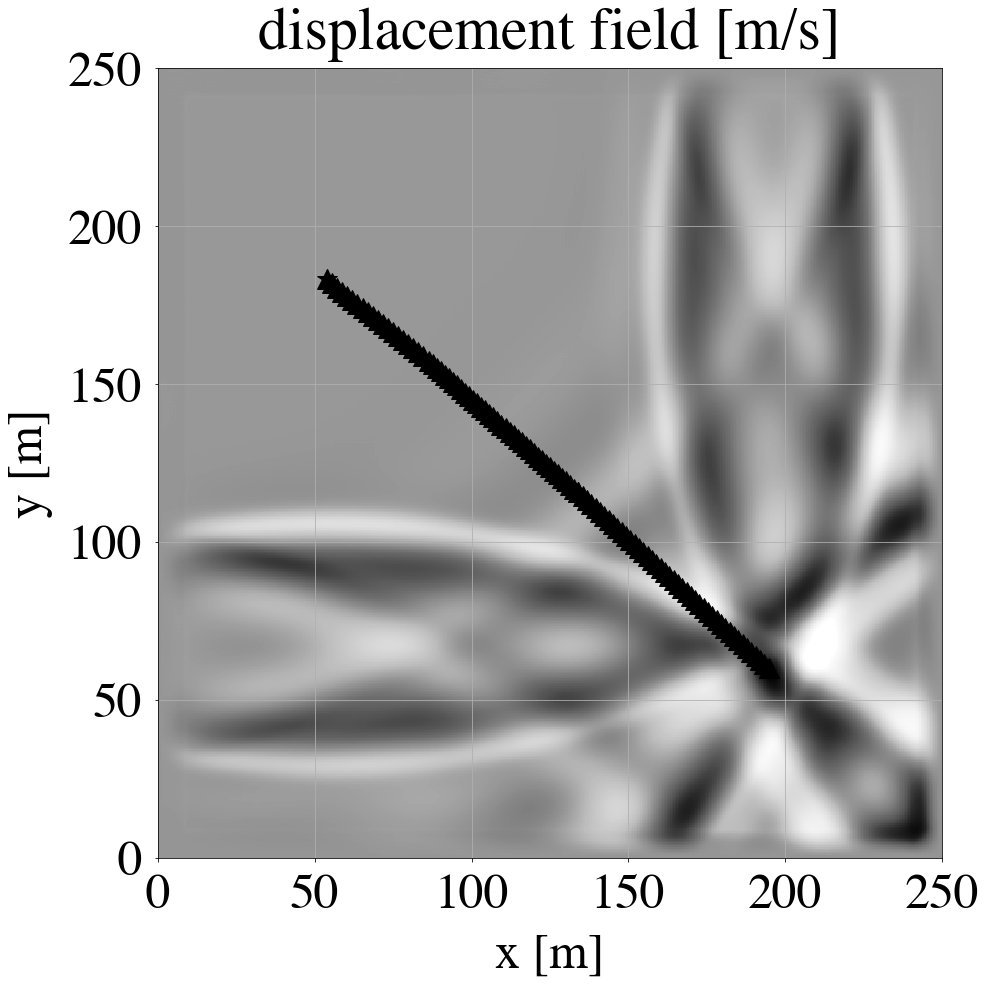

In [60]:
# Wavefield at final time step.
plt.subplots(1, figsize=(15,15))
plt.pcolor(x,y,u.transpose(),cmap='Greys')
plt.plot(x_src,y_src,'k*',MarkerSize=20)
for i in range(len(x_rec)): plt.plot(x_rec[i],y_rec[i],'k^',MarkerSize=20)
plt.xlabel('x [m]',labelpad=15)
plt.ylabel('y [m]',labelpad=15)
plt.title('displacement field [m/s]',pad=20)
maxval=0.75*np.max(np.abs(u))
plt.clim([-maxval,maxval])
plt.grid()
plt.tight_layout()
filename='IO/u_'+str(nt)+'.png'
plt.savefig(filename,format='png',dpi=500)
plt.show()

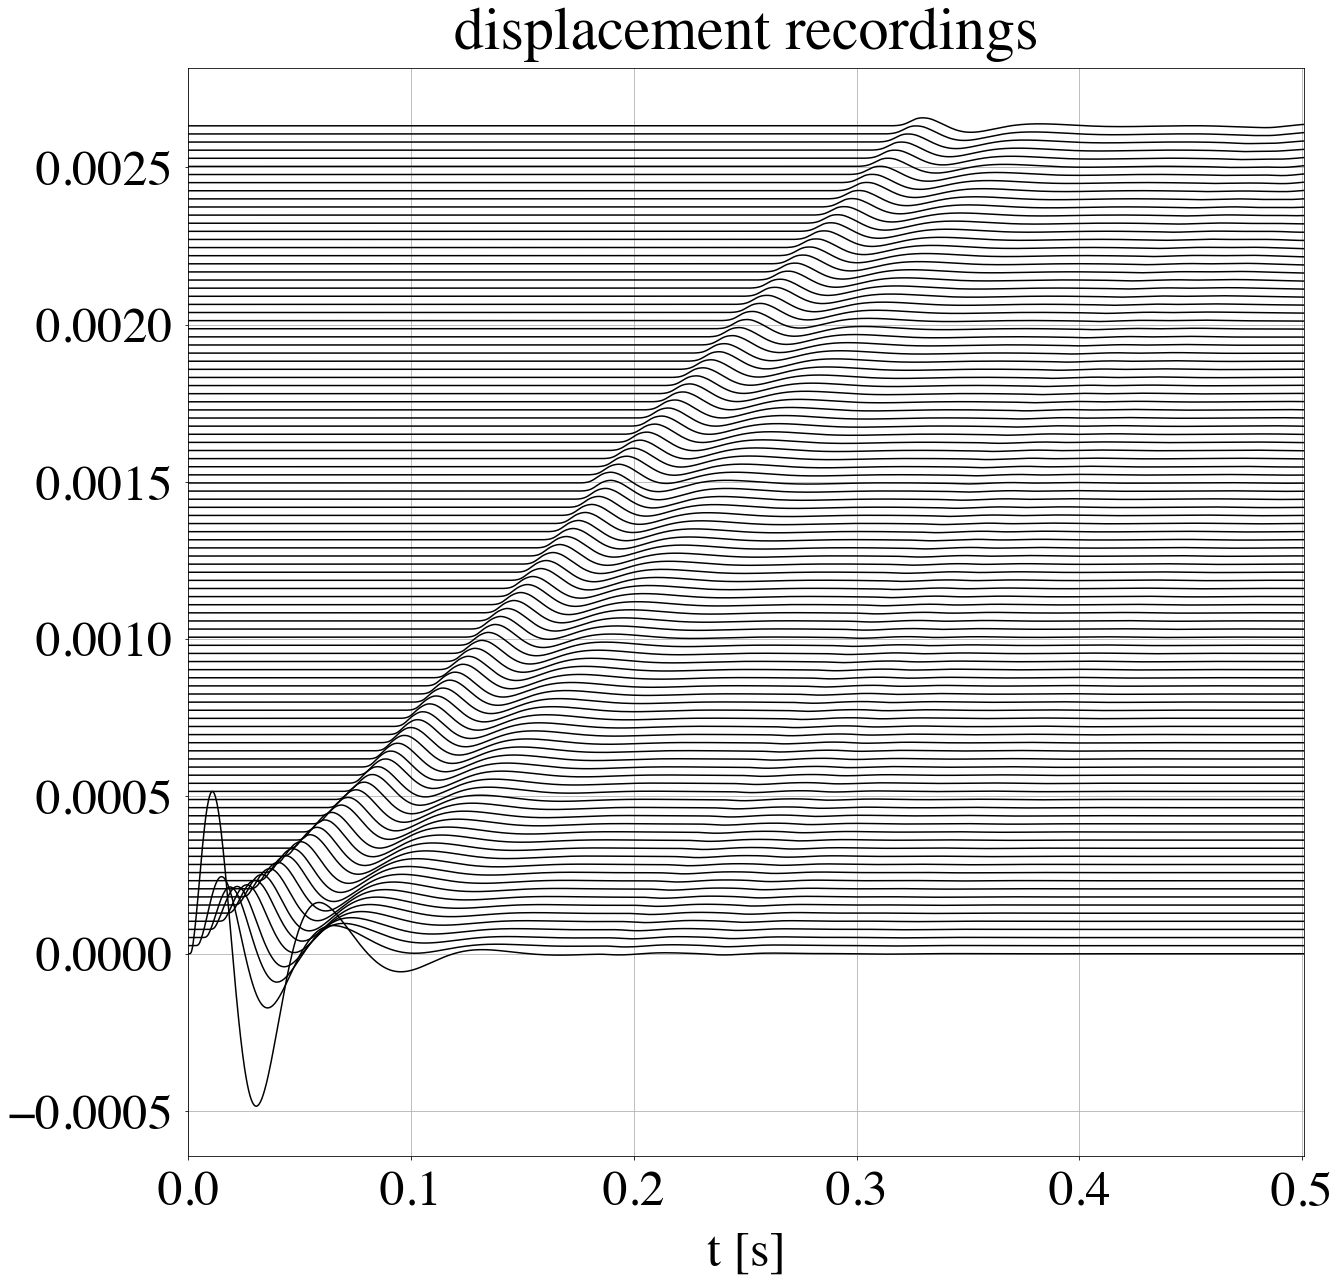

In [62]:
# Displacement recordings at receivers.
scale=0.05*np.max(u_rec)
plt.subplots(1, figsize=(20,20))
for i in range(len(x_rec)): plt.plot(t,float(i)*scale+u_rec[i,:],'k')
plt.xlabel('t [s]',labelpad=15)
plt.xlim([0,nt*dt])
plt.title('displacement recordings',pad=20)
plt.grid()
plt.show()

# 5. Compute sensitivity kernel

Following the solution of the forward problem, we can compute sensitivity kernels via the solution of the adjoint problem.

## 5.1. Compute adjoint sources

As a first step, we need to compute the adjoint sources. Their precise form depends on the choice of the measurement or misfit functional, and so the box below may need modification, depending on what is needed.

In [63]:
# Interpolate time-reversed data.
data_interp=np.zeros([len(x_rec),len(t)])

for i in range(len(x_rec)):
    f=interpolate.interp1d(t_data,data[i,:])
    data_interp[i,:]=f(t)
    
# Initialise adjoint source time functions.
adsrc=np.zeros([len(x_rec),len(t)])

# Accumulate adjoint sources.
for i in range(len(x_rec)):
    adsrc[i,:]=np.flip(data_interp[i,:])

## 5.2. Initialise adjoint dynamic fields and kernel

Prior to the solution of the adjoint problem, we define all the required dynamic fields, and we set their initial values to $0$.

In [64]:
# Adjoint velocity field.
v_ad=np.zeros([nx,ny])
# Adjoint acceleration field.
a_ad=np.zeros([nx,ny])
# Adjoint stress fields.
sx_ad=np.zeros([nx,ny])
sy_ad=np.zeros([nx,ny])
# Sensitivity kernel.
K=np.zeros([nx,ny])

## 5.3. Propagate adjoint field and compute kernel on the fly

Since the wave equation defined above is self-adjoint, the numerical solution of the adjoint problem is essentially a copy of the forward problem solution above.

In [65]:
# Iterative time stepping of adjoint field.

for it in range(len(t)):
    
    # Advance adjoint stress field.
    sx_ad[1:nx-1,:]+=(dt/dx)*(v_ad[2:nx,:]-v_ad[1:nx-1,:])
    sy_ad[:,1:ny-1]+=(dt/dy)*(v_ad[:,2:ny]-v_ad[:,1:ny-1])
    # Approximate stress field at the boundary.
    sx_ad[0,:]=sx_ad[1,:]
    sx_ad[nx-1,:]=sx_ad[nx-2,:]
    sy_ad[:,0]=sy_ad[:,1]
    sy_ad[:,ny-1]=sy_ad[:,ny-2]
    # Compute acceleration.
    a_ad[1:nx-1,1:ny-1]=(c2[1:nx-1,1:ny-1]/dx)*(sx_ad[1:nx-1,1:ny-1]-sx_ad[0:nx-2,1:ny-1])+(c2[1:nx-1,1:ny-1]/dy)*(sy_ad[1:nx-1,1:ny-1]-sy_ad[1:nx-1,0:ny-2])
    # Add adjoint sources.
    for i in range(len(x_rec)): a_ad[nx_rec[i],ny_rec[i]]+=c2[nx_rec[i],ny_rec[i]]*adsrc[i,it]
    # Advance velocity field.
    v_ad+=dt*a_ad
    
    # Accumulate sensitivity kernel.
    it_rev=len(t)-it
    if it_rev in i_store: 
        idx=np.where(i_store==it_rev)[0][0]
        K+=v_ad*v_store[:,:,idx]
        
# Correct scaling of sensitivity kernel.
K=-2.0*dt*K*float(nt_store)/c**3

## 5.4. Visualisation

Finally, we visualise the sensitivity kernel.

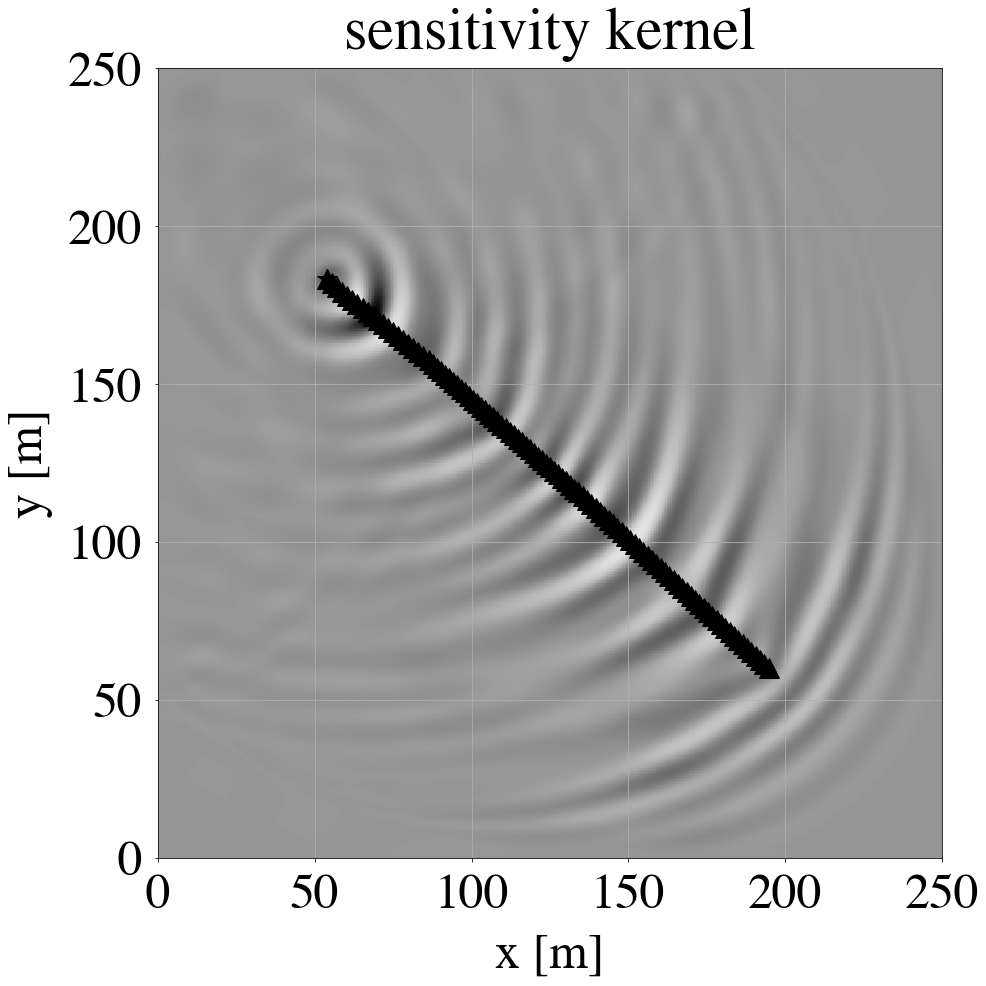

In [66]:
plt.subplots(1, figsize=(15,15))
plt.pcolor(xx,yy,K,cmap='Greys')
plt.plot(x_src,y_src,'k*',MarkerSize=20)
for i in range(len(x_rec)): plt.plot(x_rec[i],y_rec[i],'k^',MarkerSize=20)
plt.xlabel('x [m]',labelpad=15)
plt.ylabel('y [m]',labelpad=15)
plt.title('sensitivity kernel',pad=20)
maxval=0.85*np.max(np.abs(K))
plt.clim([-maxval,maxval])
plt.grid()
plt.tight_layout()
plt.savefig('./IO/kernel.png',format='png',dpi=500)
plt.show()